## DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORK

In [114]:
#import libreries
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle as pkl

train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("Training on GPU")
else:
    print("Training on CPU")

Training on GPU


## Getting Data

In [115]:
from torchvision import datasets
from torchvision import transforms

#tensor transform
transform = transforms.ToTensor()

#SVHN: Street View Home Numbers
svhn_train = datasets.SVHN(root="data/", split="train", download=True, transform = transform)

batch_size = 128
num_workers = 0

train_loader = torch.utils.data.DataLoader(dataset = svhn_train,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          num_workers = num_workers)


Using downloaded and verified file: data/train_32x32.mat


## Visualize Data

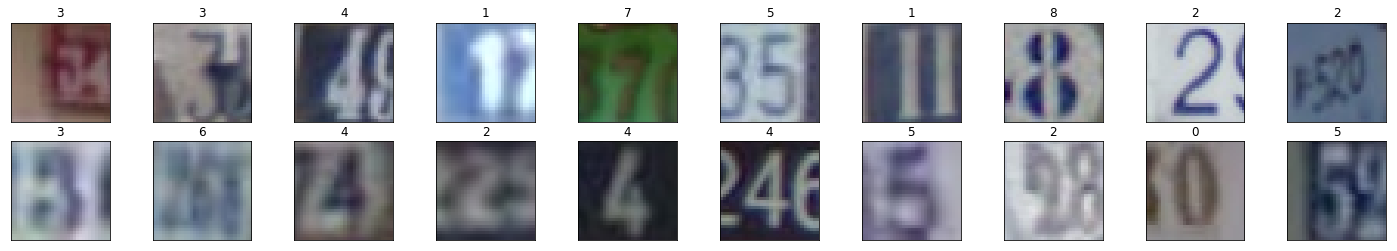

In [116]:
dataIter = iter(train_loader)
images, labels = dataIter.next()

fig = plt.figure(figsize= (25, 4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1,2,0)))
    ax.set_title(str(labels[idx].item()))

## Preprocessing: Scale from -1, 1
Thanh activation functions returns (-1, 1). So, we need to scale images.
https://pytorch.org/docs/stable/nn.html#torch.nn.Tanh

In [117]:
print(images.shape)
img = images[0]
print(img.shape)

print("Min: {}, Max: {}".format(img.min(), img.max()))

torch.Size([128, 3, 32, 32])
torch.Size([3, 32, 32])
Min: 0.08235294371843338, Max: 0.6392157077789307


In [118]:
def scale(x, feature_range=(-1, 1)):
    min, max = feature_range
    x = x*(max-min) + min
    return x

In [119]:
scaled_img = scale(img)
print("Scaled min: {}\nScaled max: {}".format(scaled_img.min(), scaled_img.max()))

Scaled min: -0.8352941274642944
Scaled max: 0.27843141555786133


## Define the Model

### Discriminator

* The input of the discriminator are 32\*32\*3 tensor image
* You'll want a fea convolutional hidden layers
* Then a fully connected layer for the output; as before, we want a sigmoid output, but we'll add that in the loss function, https://pytorch.org/docs/stable/nn.html#torch.nn.BCEWithLogitsLoss

<img src='assets/conv_discriminator.png' width=80%/>

### Helper conv function

Convolution > batch norm > leaky ReLU  + Sequential Container

In [120]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

Note: It is also suggested that you use kernel_size = 4 and stride = 2 for strided convolutions

In [121]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        #32*32
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        #16*16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        #8*8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        #4*4 out
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
    
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = out.view(-1, conv_dim*4*4*4)
        out = self.fc(out)
        return out

### Generator


The input will be out noise vector <b>z</b>. The output will be <i>tanh</i> output, but this time with size 32\*32 which is the size of our SVHN images. 

<img src='assets/conv_generator.png' width=80% />

What's new here is we'll use transpose convolutional layers to create our new images.

* The first layer is fully connected layer which is reshaped into a deep and narrow layer, something like 4\*4\*512 
* Then, we use batch normalization and a leaky ReLU activation.
* Next is a series of [transpose convolutional layers](https://pytorch.org/docs/stable/nn.html#convtranspose2d), where you typically halve the depth and double the width and height of the previous layer.
* And, we'll apply batch normalization and ReLU to all but the last of these hidden layers. Where we will just apply a <i>tanh</i> activation.

### Helper deconv function

Transpose Convolution > batch norm > ReLU

Note: It's also suggested that you use a <b>kernel_size of 4</b> abd <b>stride of 2</b> for transpose convolutions.

In [122]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    trans_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(trans_conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)    

In [123]:
class Generator(nn.Module):
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        
    def forward(self, x):
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        #hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        #last layer + tanh activation function
        out = F.tanh(self.t_conv3(out))
        return out

## Build complete network

In [124]:
# define hyperparameters
conv_dim = 32
z_size = 100

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(z_size, conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

## Training with GPU

In [125]:
if train_on_gpu:
    G.cuda()
    D.cuda()
    print("GPU Available for training. Models moved to GPU")
else:
    print("Training on CPU")

GPU Available for training. Models moved to GPU


### Discriminator and Generator losses

Discriminator loss is the sum of the losses for real and fake images

<b>d_loss = d_real_loss + d_fake_loss</b>

Discriminator for output <b>1</b> for real images and <b>0</b> for fake images.

The losses will be BCEWIthLogitsLoss. This combines <b>sigmoid</b> activation function and binary cross entropy loss in one function.

In [127]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

### Optimizers and Hyperparameters

In [128]:
import torch.optim as optim

lr = 0.0002
beta1=0.5
beta2=0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Training

Training involves alternating between Discriminator and Generator. We will use <i>real_loss</i> and <i>fake_loss</i> to help us calculate the discriminator losses in all of the following cases:

### Discriminator training

1.- Compute the discriminator loss on real, training images

2.- Generate fake images

3.- Compute the discriminator loss on fake, generated images

4.- Add up real and fake loss

5.- Perform backpropagation + an optimization step to update the discriminator's weight


### Generator training

1.- Generate fake images

2.- Compute the discriminator loss on fake images, using <b>flipped</b> labels!

3.- Perform backpropagation + an optimization step to update the generator's weights.

### Saving samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

### Evaluation mode

When we call our generator to create the samples to display, we set our model to evaluation mode <b>G.eval()</b>. That's so the batch normalization layer will use the population statistics rathen than the batch statistics (as they do during training), so dropout layers will operate in eval mode; not turning off any nodes for generating samples.

In [129]:
import pickle as pkl

# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = scale(real_images)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   50] | d_loss: 1.4363 | g_loss: 0.7292
Epoch [    1/   50] | d_loss: 0.2774 | g_loss: 3.8066
Epoch [    2/   50] | d_loss: 0.6637 | g_loss: 2.0729
Epoch [    2/   50] | d_loss: 0.5777 | g_loss: 1.7048
Epoch [    3/   50] | d_loss: 2.7750 | g_loss: 0.2135
Epoch [    3/   50] | d_loss: 0.5707 | g_loss: 2.1308
Epoch [    4/   50] | d_loss: 1.1038 | g_loss: 2.9349
Epoch [    4/   50] | d_loss: 0.4978 | g_loss: 2.3530
Epoch [    5/   50] | d_loss: 0.5008 | g_loss: 1.9522
Epoch [    5/   50] | d_loss: 0.5737 | g_loss: 1.7872
Epoch [    6/   50] | d_loss: 0.7587 | g_loss: 3.6664
Epoch [    6/   50] | d_loss: 0.2474 | g_loss: 2.2806
Epoch [    7/   50] | d_loss: 0.4345 | g_loss: 3.0192
Epoch [    7/   50] | d_loss: 0.3773 | g_loss: 2.6657
Epoch [    8/   50] | d_loss: 0.4363 | g_loss: 2.0920
Epoch [    8/   50] | d_loss: 0.8457 | g_loss: 3.7620
Epoch [    9/   50] | d_loss: 0.3099 | g_loss: 2.6149
Epoch [    9/   50] | d_loss: 0.2555 | g_loss: 2.2215
Epoch [   10/   50] | d_loss

## Training loss

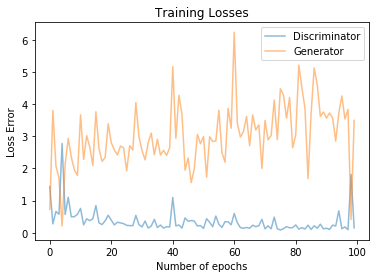

In [130]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label="Discriminator", alpha=0.5)
plt.plot(losses.T[1], label="Generator", alpha=0.5)
plt.title("Training Losses")
plt.xlabel("Number of epochs")
plt.ylabel("Loss Error")
plt.legend()

## Generator samples from training


In [134]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16, 4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1,2,0))
        img = ((img+1)*255/(2)).astype(np.uint8)
        ax.xaxis.set_visible(True)
        ax.yaxis.set_visible(True)
        im = ax.imshow(img.reshape((32,32,3)))

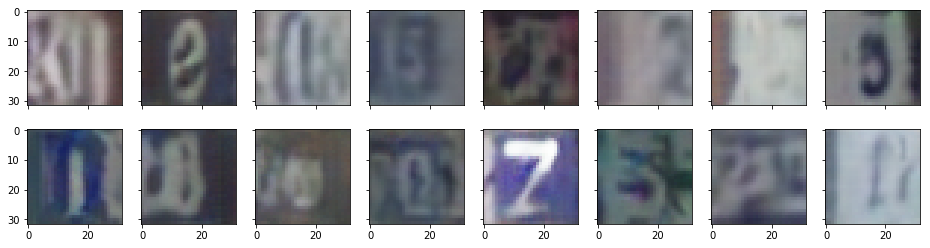

In [135]:
_ = view_samples(-1, samples)

In [140]:
# confi2

# define hyperparameters
conv_dim2 = 32
z_size2 = 200

# define discriminator and generator
D2 = Discriminator(conv_dim2)
G2 = Generator(z_size2, conv_dim2)

print(D2)
print()
print(G2)

if train_on_gpu:
    D2 = D2.cuda()
    G2 = G2.cuda()

lr2 = 0.00002
beta1=0.5
beta2=0.999

d_optimizer2 = optim.Adam(D2.parameters(), lr2, [beta1, beta2])
g_optimizer2 = optim.Adam(G2.parameters(), lr2, [beta1, beta2])

# training hyperparams
num_epochs2 = 70

# keep track of loss and generated, "fake" samples
samples2 = []
losses2 = []

print_every2 = 300

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size2=16
fixed_z2 = np.random.uniform(-1, 1, size=(sample_size2, z_size2))
fixed_z2 = torch.from_numpy(fixed_z2).float()

# train the network
for epoch2 in range(num_epochs2):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = scale(real_images)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer2.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        
        D_real2 = D2(real_images)
        d_real_loss2 = real_loss(D_real2)
        
        # 2. Train with fake images
        
        # Generate fake images
        z2 = np.random.uniform(-1, 1, size=(batch_size, z_size2))
        z2 = torch.from_numpy(z2).float()
        # move x to GPU, if available
        if train_on_gpu:
            z2 = z2.cuda()
        fake_images2 = G(z2)
        
        # Compute the discriminator losses on fake images            
        D_fake2 = D2(fake_images2)
        d_fake_loss2 = fake_loss(D_fake2)
        
        # add up loss and perform backprop
        d_loss2 = d_real_loss2 + d_fake_loss2
        d_loss2.backward()
        d_optimizer2.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer2.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z2 = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z2 = torch.from_numpy(z2).float()
        if train_on_gpu:
            z2 = z2.cuda()
        fake_images2 = G2(z2)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake2 = D2(fake_images2)
        g_loss2 = real_loss(D_fake2) # use real loss to flip labels
        
        # perform backprop
        g_loss2.backward()
        g_optimizer2.step()

        # Print some loss stats
        if batch_i % print_every2 == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss2.item(), g_loss2.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch2+1, num_epochs2, d_loss2.item(), g_loss2.item()))

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G2.eval() # for generating samples
    if train_on_gpu:
        fixed_z2 = fixed_z2.cuda()
    samples_z2 = G2(fixed_z2)
    samples2.append(samples_z2)
    G2.train() # back to training mode


# Save training generator samples
with open('train_samples_config1.pkl', 'wb') as f:
    pkl.dump(samples, f)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=200, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

RuntimeError: size mismatch, m1: [128 x 200], m2: [100 x 2048] at /opt/conda/conda-bld/pytorch_1550802451070/work/aten/src/THC/generic/THCTensorMathBlas.cu:266